In [1]:
#Using pandas.pydata.org and numpy.org for libraries reference
#Romi Tshiorny
#Assignment 2

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing

#Read the data and make sure its properly stored as a variable

titanic_data = pd.read_csv('titanic.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
from sklearn.model_selection import train_test_split

# Code for splitting titanic data into training and test sets
# Comment out if you want to manually choose train and test
#------------------------------------------------------------
train, test = train_test_split(titanic_data, test_size = 0.25, random_state = 1)
train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)
#------------------------------------------------------------

train = pd.read_csv('train.csv');
test = pd.read_csv('test.csv');

In [3]:
# Clean up the data a little bit to get rid of NaN values and labels

# Find the mean age
train_mean_age = train['Age'].mean()
test_mean_age = test['Age'].mean()

# Fill all NaN ages with the mean age of the data set
train['Age'] = train['Age'].fillna(train_mean_age)
test['Age'] = test['Age'].fillna(train_mean_age)

# Find the mean fare
train_mean_fare = train['Fare'].mean()
test_mean_fare = test['Fare'].mean()

# Fill all NaN ages with the mean fare of the data set
train['Fare'] = train['Fare'].fillna(train_mean_fare)
test['Fare'] = test['Fare'].fillna(train_mean_fare)


train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])

In [4]:
# Drop categories that aren't useful

train = train.drop(['Name', 'Parch','SibSp', 'Ticket','Cabin'], axis=1)

In [5]:
# Categorize continuous features into binary thresholds and fix labels

# https://www.absentdata.com/pandas/pandas-cut-continuous-to-categorical/
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


train.loc[train['Age'] < 65, 'Age Group'] = 'Adult'
train.loc[train['Age'] <= 17, 'Age Group'] = 'Young'
train.loc[train['Age'] >= 65, 'Age Group'] = 'Old'

test.loc[test['Age'] < 65, 'Age Group'] = 'Adult'
test.loc[test['Age'] <= 17, 'Age Group'] = 'Young'
test.loc[test['Age'] >= 65, 'Age Group'] = 'Old'

train.loc[train['Fare'] <= train_mean_fare, 'Fare Group'] = 'Below'
train.loc[train['Fare'] > train_mean_fare, 'Fare Group'] = 'Above'

test.loc[test['Fare'] <= test_mean_fare, 'Fare Group'] = 'Below'
test.loc[test['Fare'] > test_mean_fare, 'Fare Group'] = 'Above'

# Change lables to float values for tree categorization
labeler = preprocessing.LabelEncoder()


train['Age Group'] = labeler.fit_transform(train['Age Group'])
test['Age Group'] = labeler.transform(test['Age Group'])

train['Embarked'] = labeler.fit_transform(train['Embarked'])
test['Embarked'] = labeler.transform(test['Embarked'])

train['Sex'] = labeler.fit_transform(train['Sex'])
test['Sex'] = labeler.transform(test['Sex'])

train['Fare Group'] = labeler.fit_transform(train['Fare Group'])
test['Fare Group'] = labeler.transform(test['Fare Group'])


In [6]:
# Node object for building the tree
class DecisionNode:
    def __init__(self, decision = None, depth = 0, max_depth = None):
        self.label = None
        self.children = dict()      
        self.decision = decision
        self.output = None
        self.depth = depth
        self.max_depth = max_depth
        self.prob = None
    
    #Recursively build child notes based on attributes
    def build(self, S, attributes, classifier):
        # Attribute chosen to split node provide maximum info gain
        self.label = self.max_gain_attribute(S, attributes, classifier)
        
        end_growth = False
        if(self.max_depth != None):
            end_growth = self.depth >= self.max_depth
        # Gain == 0 when label == None
        if(self.label == None or end_growth):
                self.label = 'leaf'
                total_count = S[classifier].size
                positive_count = S.loc[S[classifier] == 1, classifier].size
                negative_count = total_count - positive_count;             
                self.output = 1 if positive_count >= negative_count else 0
                self.prob = positive_count/total_count if positive_count >= negative_count else negative_count/total_count
        else:        
            values = S[self.label].unique()
            new_attributes = attributes.copy()
            new_attributes.remove(self.label)
            for v in values:
                new_s = S.loc[S[self.label]==v]
                new_node = DecisionNode(v, self.depth + 1, self.max_depth)
                new_node.build(new_s,new_attributes,classifier)
                self.children[v] = new_node
                
    def classify(self, S):
        #print(S.at[0,self.label])
        if(self.label == 'leaf'):
             return self.output
        else:
            next_node = self.children[S.at[S.index[0],self.label]]
            return next_node.classify(S)
            
    def probability(self, S):
        if(self.label == 'leaf'):
                return self.prob
        else:
            next_node = self.children[S.at[S.index[0],self.label]]
            return next_node.probability(S)
    # Display all the attributes of the node
    def visualize(self):
        print("     "*self.depth,"-----------------")
        print("     "*self.depth,"Label: ",self.label)
        print("     "*self.depth,"Decision: ", self.decision)
        print("     "*self.depth,"Classification: ", self.output)
        print("     "*self.depth,"Depth: ", self.depth)
        print("     "*self.depth,"-----------------")
        for key in self.children.keys():
            self.children[key].visualize()
        
    # Function for calculating the entropy of a set
    def entropy(self,S, classifier, attributes):
        total_count = S[classifier].size
        positive_count = S.loc[S[classifier] == 1, classifier].size
        negative_count = total_count - positive_count;
        p_p = positive_count/total_count
        p_n = negative_count/total_count

        if(p_n == 0 or p_p == 0):
            return 0
        else:
            return -(p_p*math.log2(p_p)+p_n*math.log2(p_n))

    # Function for calculating information gain of an attribute 
    def gain(self,S, attribute, classifier):
        attributes = S[attribute].unique() 
        total_entropy = self.entropy(S, classifier, attributes)
        partial_entropy = 0
        for v in attributes:
            s_partial = S.loc[S[attribute] == v]
            ratio = s_partial.size/S.size
            partial_entropy = partial_entropy + ratio*self.entropy(s_partial, classifier, attributes)

        return total_entropy - partial_entropy

    # Function for calculating the label that grants the most infromation gain
    def max_gain_attribute(self,S, labels, classifier):
        max_gain = 0
        max_label = None
        for label in labels:
            c_gain = self.gain(S,label,classifier)
            if(c_gain > max_gain):
                max_gain = c_gain
                max_label = label

        return max_label           

In [7]:
# Decision Tree object
class DecisionTree:
    def __init__(self, max_depth = None):
        if(max_depth != None and max_depth <= 0):
            print("MAX DEPTH MUST BE > 0")
        else:
            self.max_depth = max_depth
            self.built_attributes = None
        
        
    #build the tree from the data and the attributes/classifier
    def build(self, S, input_attributes, classifier):
        if(len(input_attributes) == 0):
            print("NO ATTRIBUTES SPECIFIED")
        elif(S.size == 0):
            print("NO DATA")
        else:
            self.root = DecisionNode('root',max_depth = self.max_depth)
            self.classifier = classifier
            self.built_attributes = input_attributes
            self.root.build(S, input_attributes, classifier)
    
    # Method to visualize the tree structure
    # (couldn't figure out how to you python libraries to do so)
    def display(self):
        self.root.visualize()
        
    # Test a singular case against the tree
    def test(self, S):
        return self.root.classify(S)
    
    # score based on how many of the test examples are evaluated correctly
    def score(self,S):
        #iterate through all the tests
        success_count = 0
        for i in range(len(S.index)):
            result = S.at[S.index[i],self.classifier]
            classification = self.test(S.iloc[[i]])
            if(result == classification):
                success_count += 1
                  
        return success_count/len(S.index)
   
    # calculated predicted probabilities for each value
    def predict_prob(self,S):
        #iterate through all the tests
        prob = [[],[]]
        for i in range(len(S.index)):
            classification = self.test(S.iloc[[i]])
            if(classification == 0):
                p = self.root.probability(S.iloc[[i]])
                prob[0].append(p)
                prob[1].append(1-p)
            else:
                p = self.root.probability(S.iloc[[i]])
                prob[1].append(p)
                prob[0].append(1-p)
                
                  
        return prob
    
    # returns number of true positives, false positives, true negatives and false negatives
    def accuracy_breakdown(self,S):
        tp_count = 0
        fp_count = 0
        tn_count = 0
        fn_count = 0
        for i in range(len(S.index)):
            result = S.at[S.index[i],self.classifier]
            classification = self.test(S.iloc[[i]])
            #if result should be positive:
            if(result == 1):
                #True positive
                if(classification == result):
                    tp_count += 1
                #False negative
                else:
                    fn_count += 1     
            #if result should be negative:
            else:
                #True negative
                if(classification == result):
                    tn_count += 1
                #False positive
                else:
                    fp_count += 1
            
        return tp_count, fp_count, tn_count, fn_count
        

In [8]:
# Build the tree
my_tree = DecisionTree()
#my_tree = DecisionTree(max_depth=3)
my_tree.build(train, ['Sex','Age Group','Pclass'], 'Survived')
my_tree.display()
print("score: ",my_tree.score(test))


#my_tree.build(df,['wind','humidity','outlook'],'playtennis')
#my_tree.display()
#my_tree.score(df_test)


 -----------------
 Label:  Sex
 Decision:  root
 Classification:  None
 Depth:  0
 -----------------
      -----------------
      Label:  Age Group
      Decision:  1
      Classification:  None
      Depth:  1
      -----------------
           -----------------
           Label:  Pclass
           Decision:  0
           Classification:  None
           Depth:  2
           -----------------
                -----------------
                Label:  leaf
                Decision:  1
                Classification:  0
                Depth:  3
                -----------------
                -----------------
                Label:  leaf
                Decision:  3
                Classification:  0
                Depth:  3
                -----------------
                -----------------
                Label:  leaf
                Decision:  2
                Classification:  0
                Depth:  3
                -----------------
           -----------------
           

In [9]:
# Save object as pkl
# Found a way to do this here:
# https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence
import pickle

def save(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj,output,pickle.HIGHEST_PROTOCOL)
        
save(my_tree, 'decision_tree.pkl')

<AxesSubplot:>

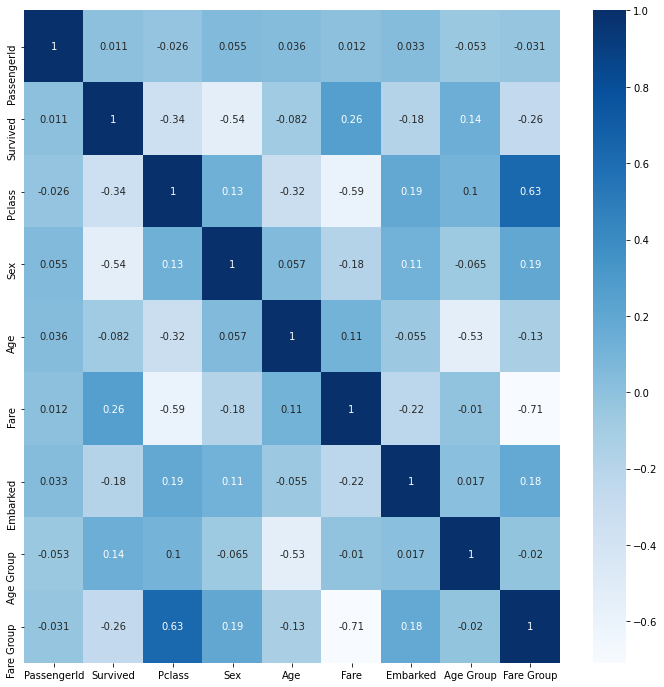

In [10]:
#Confusion matrix for base training data
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

plt.figure(figsize=(12,12))
sb.heatmap(train.corr(), annot=True,cmap = 'Blues')

In [11]:
#Reduced data for simplicity of tree, other data can be added
#Example, Pclass and Fare have high correllation 
#(as seen in the confusion matrix) so I just chose Pclass


all_train_inputs = train[['Sex','Age Group','Pclass']].values
all_train_outputs = train['Survived'].values

all_test_inputs = test[['Sex','Age Group','Pclass']].values
all_test_outputs = test['Survived'].values

score:  0.757847533632287


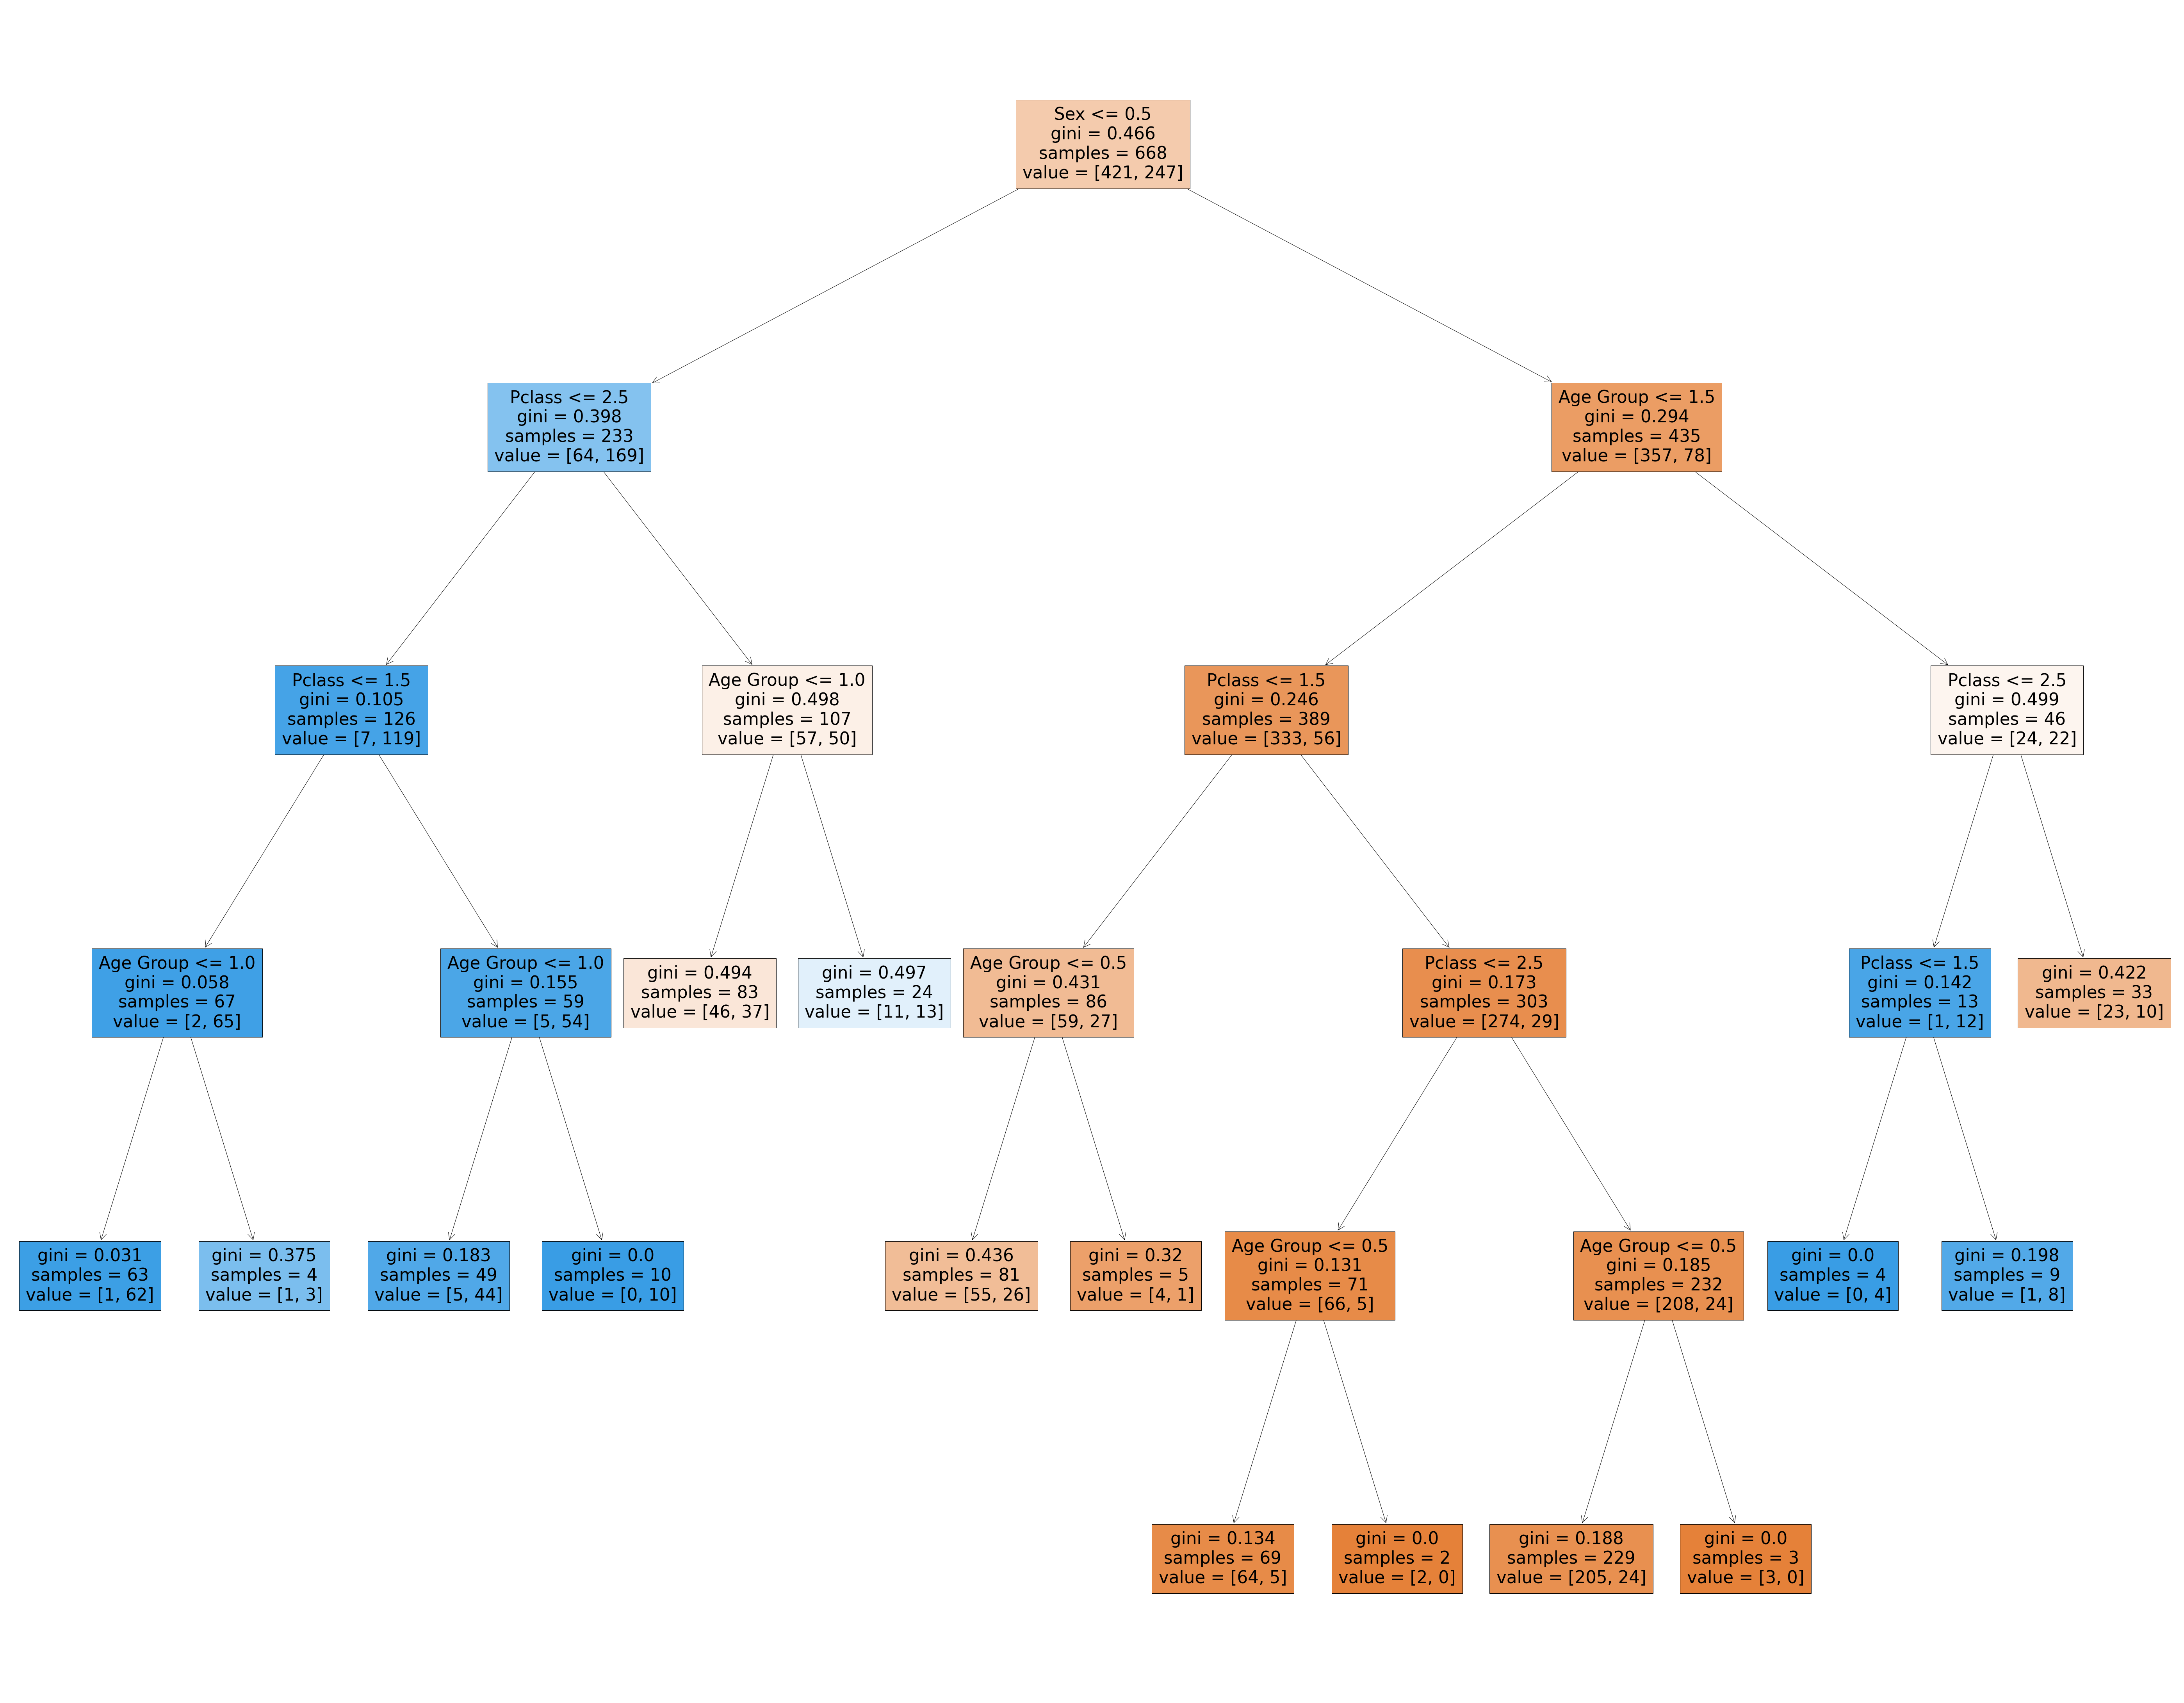

In [12]:
#Standard sklearn decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


decision_tree_classifier = DecisionTreeClassifier()
#decision_tree_classifier = DecisionTreeClassifier(max_depth = 3)
decision_tree_classifier.fit(all_train_inputs, all_train_outputs)

# Note: the sklearn score matches the score for my tree exactly
print("score: ",decision_tree_classifier.score(all_test_inputs,all_test_outputs))

#Print model for sklearn decision tree
fig = plt.figure(figsize=(100,80))
_ = tree.plot_tree(decision_tree_classifier, feature_names= ['Sex','Age Group','Pclass'], filled = True)
fig.savefig("decision_tree.png")

In [13]:
#Using 10-fold cross validation


#On sklearn tree (as done in iris example)
from sklearn.model_selection import cross_val_score
decision_tree_Kclassifier = DecisionTreeClassifier()

cv_scores = cross_val_score(decision_tree_Kclassifier, all_train_inputs, all_train_outputs, cv=10)
print('Max score sklearn: {}'.format(np.max(cv_scores)))

#On my decision tree

# function for kfolding
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
from sklearn.model_selection import KFold
def kfold(tree, S, attributes,classifier,k = 10):
    kf = KFold(n_splits = k)
    scores = []
    max_score = 0
    best_training_set = None
    best_tree = None
    for train_index, test_index in kf.split(S):
        tree.build(S.iloc[train_index], attributes, classifier)
        score = tree.score(S.iloc[test_index])
        scores.append(score)     
            
        if(score > max_score):
            max_score = score
            best_training_set = S.iloc[test_index]
            best_tree = tree
    
    return scores, best_training_set, best_tree
    
# Perform the kfolds and print the max score
# Seems like my Tree slightly performs better in this case on the same data
my_scores, best_train, best_tree = kfold(my_tree, train, ['Sex','Age Group','Pclass'], 'Survived', 10)
print('Max score my tree: {}'.format(np.max(my_scores)))

Max score sklearn: 0.835820895522388
Max score my tree: 0.8805970149253731


<AxesSubplot:>

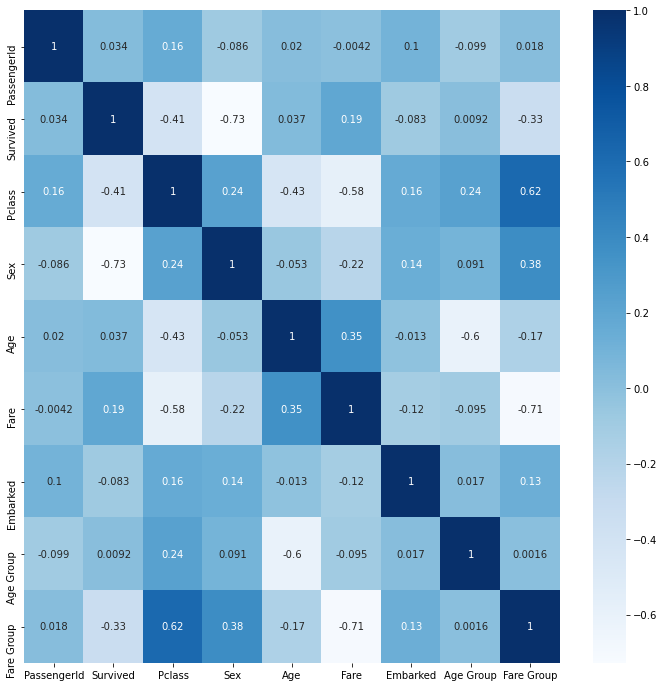

In [14]:
#Confusion matrix for best training set from my 10-fold validation
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

plt.figure(figsize=(12,12))
sb.heatmap(best_train.corr(), annot=True,cmap = 'Blues')

In [15]:
# Accuracy, precision and recall of my tree
# based off test samples
# Formulas found here: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
print("Stats for my decision tree")
accuracy = best_tree.score(test)
print('Accuracy: ', accuracy)

true_pos, false_pos, true_neg, false_neg = best_tree.accuracy_breakdown(test)

precision = (true_pos)/(true_pos + false_pos)
recall = (true_pos)/(true_pos+false_neg)

print('Precision: ', precision)
print('Recall: ', recall)

Stats for my decision tree
Accuracy:  0.757847533632287
Precision:  0.8596491228070176
Recall:  0.5157894736842106


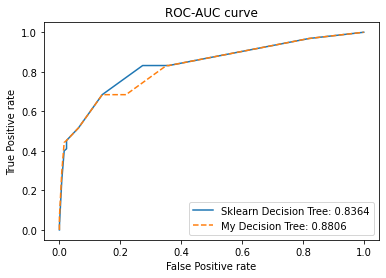

In [16]:
#ROC-AUC comparison
#Help for ROC curves found on:
#https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

sklearn_p_probability = decision_tree_classifier.predict_proba(all_test_inputs)

sk_false_positive_rate, sk_true_positive_rate, sk_threshold = \
    roc_curve(all_test_outputs, sklearn_p_probability[:,1])

sk_score = roc_auc_score(all_test_outputs, sklearn_p_probability[:,1]).round(4)


my_prob = best_tree.predict_prob(test)

my_fpr, my_tpr, my_thresh = roc_curve(all_test_outputs, my_prob[1])

plt.plot(sk_false_positive_rate, sk_true_positive_rate, label = 'Sklearn Decision Tree: {}'.format(sk_score))
plt.plot(my_fpr, my_tpr, label = 'My Decision Tree: {}'.format(np.max(my_scores).round(4)), linestyle = 'dashed')
plt.title('ROC-AUC curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')

plt.legend()
plt.show()

Looks like my decision tree performs very similarly to the sklearn tree, with the small exception around the 0.2 threshold mark where it performs slightly worse. According to my calculation though my tree has better accuracy (but that could just have been an error on my end)